In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
df = pd.read_csv('data/df_final.csv')

In [7]:
corr_matrix = df.corr()
corr_matrix['price'].sort_values(ascending = False)

price                     1.000000
non_family_mean_income    0.418229
household_mean_income     0.366494
square_meter              0.361733
bathroom_number           0.349462
postcode                  0.330218
family_mean_income        0.296516
bedroom_number            0.234776
non_family_number        -0.003537
population               -0.007218
household_number         -0.046922
families_number          -0.075762
latitude                 -0.101964
longitude                -0.315682
Name: price, dtype: float64

In [8]:
df.describe()

,postcode,latitude,longitude,bedroom_number,bathroom_number,square_meter,population,price,household_number,household_mean_income,families_number,family_mean_income,non_family_number,non_family_mean_income
count,25848.000000,25848.000000,25848.000000,25848.000000,25848.000000,25848.000000,2.584800e+04,25848.000000,25848.000000,25848.000000,25848.000000,25848.000000,25848.000000,25848.000000
mean,81360.142216,37.103480,-108.722259,1.987156,1.864709,109.961660,2.522476e+06,429966.887457,14731.271626,110176.907459,7871.578846,140860.115289,6859.692781,75420.457521
std,13736.206639,6.565142,17.772234,0.726330,0.715548,40.730158,3.443152e+06,230441.131692,7436.710669,40905.306914,4377.318873,63664.565439,4895.020135,27487.105711
min,52722.000000,19.133127,-159.545010,1.000000,1.000000,49.000000,4.300000e+01,50000.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,65616.000000,33.587539,-118.470099,2.000000,1.000000,81.000000,6.195200e+04,249500.000000,9882.000000,81279.750000,4897.000000,94638.500000,3532.000000,55922.000000
50%,85054.000000,37.630486,-111.856490,2.000000,2.000000,102.000000,4.225750e+05,390000.000000,13860.000000,101923.000000,7366.000000,122246.000000,5670.000000,70155.000000
75%,92688.000000,41.873860,-91.160582,2.000000,2.000000,130.000000,3.557982e+06,579000.000000,19033.000000,133202.000000,10276.000000,169882.750000,8579.000000,89889.000000
max,99901.000000,64.854095,-87.548485,6.000000,7.000000,299.000000,1.253133e+07,1000000.000000,41335.000000,373083.000000,29789.000000,471242.000000,25265.000000,579726.000000


In [13]:
df['income_cat'] = pd.cut(df['non_family_mean_income'], bins= [20000., 40000, 60000, 80000, 100000., np.inf], labels = [1,2,3,4,5])

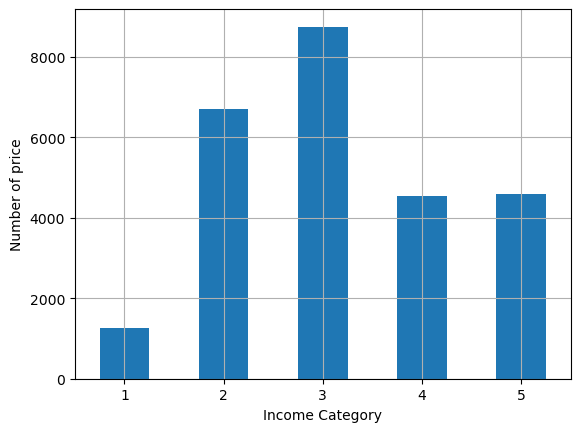

In [14]:
df['income_cat'].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel('Income Category')
plt.ylabel('Number of price')
plt.show()